1217
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Tony Blair']
George W Bush
0.868852459016


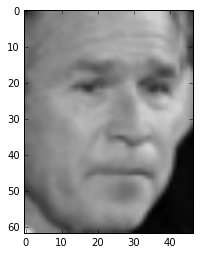

In [66]:
#Claire Roush
#CS 147 - Prof. Manley
#Project 4
#Proposed points 100%
#9 November, 2016

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA #new one!
from sklearn import grid_search
import pandas
import numpy


lfw_people = fetch_lfw_people(min_faces_per_person=70)
print(len(lfw_people.images))
print(lfw_people.target_names)
plt.imshow(lfw_people.images[0], cmap='gray')
img_target = lfw_people.target[0]
print(lfw_people.target_names[img_target])
(train_data, test_data, train_target, test_target)= train_test_split(lfw_people.data, lfw_people.target, test_size = 0.2)

pca = PCA(n_components=50,whiten=True)
pca.fit(train_data)
transformed_train_data = pca.transform(train_data) 
transformed_test_data = pca.transform(test_data)
#transformed_train_target = pca.transform(train_target)
#transformed_test_target = pca.transform(test_target)

param_grid = [{'kernel': ['rbf'],  'gamma':[1,1e-1,1e-2,1e-3,1e-4,1e-5,'auto'], 'C': [1e-2,1e-1, 1, 10, 100, 1000], 'tol':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]},
            {'kernel': ['linear'], 'C': [1e-2,1e-1, 1, 10, 100, 1000],'tol':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]},
             {'kernel':['poly'], 'degree':[1,2,3,4,5,6], 'C': [1e-2,1e-1, 1, 10, 100, 1000], 'gamma':[1,1e-1,1e-2,1e-3,1e-4,1e-5,'auto'], 'coef0':[0.01,0.1,1,2,3,4,5,6,7,8,9,10],'tol':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]},
              {'kernel':['sigmoid'],'gamma':[1,1e-1,1e-2,1e-3,1e-4,1e-5,'auto'],'C': [1e-2,1e-1, 1, 10, 100, 1000], 'coef0':[0.01,0.1,1,2,3,4,5,6,7,8,9,10],'tol':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]}
       ]


#regr_alg = grid_search.GridSearchCV(lm.SGDRegressor(), parameters)
#regr_alg.fit(mpg_train[mpg_preds],mpg_train[’mpg’])

#print(train_target)
#print(pca.components_[0])
#print(pca.components_[1])

svc = grid_search.GridSearchCV(SVC(),param_grid)
svc.fit(transformed_train_data,train_target)
predictions = svc.predict(transformed_test_data)
print(accuracy_score(predictions,test_target))



In [67]:
print('kernel ', svc.best_estimator_.kernel)
print('degree ', svc.best_estimator_.degree)
print('gamma ', svc.best_estimator_.gamma)
print('coef0 ', svc.best_estimator_.coef0)
print('C ', svc.best_estimator_.C)
print('tol ', svc.best_estimator_.tol)





kernel  rbf
degree  3
gamma  auto
coef0  0.0
C  10
tol  0.1


### Face Recognition With Support Vector Machines and Faces in the Wild Data Set ###

#### Kernels ####

The first kernel I tried was the default kernel with no parameters, which is the RBF, or Gaussian Radial Basis Function. Accuracy was an average of ```0.39``` over 10 runs. This makes sense, because with a C parameter of 1.0 (the default) and a dataset like the Faces in the Wild data set, it seems impossible for the smooth decision boundaries to capture the necessary examples, and to separate the classes, even if projected into other dimensions. The below picture (source: http://scikit-learn.org/stable/modules/svm.html) illustrates this.

![kernels](kernels.png)

From this illustration, it seemed like perhaps the polynomial kernel would work better. Without any other parameter changes, the default (C=1,gamma=auto,etc.) polynomial kernel performed much better, with an accuracy at an average of ```0.83``` over 10 runs. Just as a quick check, the average accuracy over 10 runs for the linear kernel was ```0.82```, and ```0.44``` for sigmoid. It is interesting that the linear kernel performed almost as well as the polynomial kernel with a degree of 3, but not surprising.

#### Principal Component Analysis ####

I researched Principal Component Analysis a bit, especially as it relates to, and as it's used in, facial recognition and uneconomic dense data with potentially large amounts of redundancy. I found a lot of research, namely a paper by Kyungnam Kim at the University of Maryland (http://staff.ustc.edu.cn/~zwp/teach/MVA/pcaface.pdf), which discussed the specific use of PCA in facial recognition. 

The paper discussed the mathematical specifics of PCA, as well as eigenspace projection, and implementation. 

>When a particular face is projected onto the face space, its vector into the face space describe the importance of each of those features in the face.
...
> That is, we can express the face image data in much smaller dimensions with the help of some prominent basis vectors, which in fact reflect maximum variability.

This, in particular, provided some clarity as to why PCA might be useful in this case. It relates to the latent attribute discussion we had in class. 

I began by fitting the PCA and transforming the training and testing set. Initially, I made the mistake of trying to transform the target sets as well, but quickly realized how silly that was. With default parameters in the SVM, and the only parameter altered in the PCA ```whiten=true```, accuracy was an average of ```0.42``` over 10 runs. After reading the scikitlearn PCA documentation, I tried setting ```n_components``` to ```100``` and got an average accuracy of ```0.83``` over 10 runs. Reducing ```n_components``` to 50 also yielded an average accuracy of about ```0.83``` over 10 runs. Dropping ```n_components``` to ```25``` had an average accuracy of ```0.71```, and raising to ```200``` had an average accuracy of ```71```. I decided to stay around ```50``` - good accuracy with good economics. The speed of computation has increased quite a bit with PCA transformation, absolutely worth it.

#### Grid Search ####

This step in the project was time consuming and painstaking. I made sure that all the probable possibilities were included, and tested numerous times, each run taking quite a long time. The ```shrinking``` parameter set to ```true``` seemed to cause problems, so I didn't include that in the parameter dictionary. I had a different list for each kernel. After selecting a comprehensive parameter list, the test runs took a long time. I ended up starting the run and leaving it overnight a few times. After testing, the best performing kernel was ```rbf``` with ```gamma=auto, coef0=0, C=10, tol=0.1``` with an average accuracy of ```0.869```.

#### Discussion & Conclusion ####

It is very interesting that the worse-performing kernel before PCA transformation was the ```rbf``` kernel, while it was the best performing after PCA transformation. PCA transformation reduces the dimensionality of the data, and rbf throws it into a higher dimensionality. Perhaps the noisiness and redundancy were reduced with PCA transformation, and the "important" attributes are only thrown to higher dimensionality in the ```rbf``` kernel, allowing for better, more accurate, classification. This is a semi-educated guess. I researched the ```rbf``` kernel a bit more, namely https://www.quora.com/Why-does-the-RBF-radial-basis-function-kernel-map-into-infinite-dimensional-space, which seemed to support the plausibility of my idea. 

>So the kernel function is essentially telling you: "You want to project your points into a higher dimension? Fine. But then you would need the dot products between the points in this higher dimension (because your learning algorithm needs it), right? Well, I have a neat little expression here that gives you just that."

The quora.com post isn't quite academic, but this plain-language explanation helped. 

I wrote this write-up as I progressed through the project. It's really interesting to me how I started with "RBF is definitely a bad idea" and ended with "well, RBF seems to work best, and maybe these reasons are why". It still seems a little counter-intuitive, but I believe that I have at least the start of an understanding. The final accuracy of ```0.869``` isn't bad at all, though it's not much higher than the ```0.83``` accuracy before PCA transformation and ```grid_search```. However, maybe 4 percentage points is more significant than I initially thought. 